<a href="https://colab.research.google.com/github/Rsimetti/cursoAP2020/blob/master/Semana05_Regressao_NIR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelos de regressão

Essa atividade consiste em:

- criar um notebook no Google Colab
- realizar a leitura dos dados com pandas (pode ser o mesmo dataset ou pode mudar)
- realizar a limpeza e organização dos dados para modelagem
- utilizar os algoritmos de agrupamento apresentados na semana
- REALIZAR A ANÁLISE E INTERPRETAÇÃO DOS RESULTADOS NO COLAB
- incluir as análises no notebook.

## Importar bibliotecas

In [1]:
# Importando bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calculo da segunda derivada
from scipy.signal import savgol_filter


# Divisão dos dados para treino e teste
from sklearn import model_selection
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

# Modelos de regressão
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

# Otimização dos parâmetros
from sklearn.model_selection import GridSearchCV

# Métricas dos modelos
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score )

# Auxilio no relatório
from tabulate import tabulate # Fazer as tabelas
import matplotlib.lines as mlines # Adicionar linha 45° 
import time

## Leitura e limpeza dos dados

Os dados utilizados são referentes à 278 peças de madeira de  hibridos de *Eucalyptus* spp com seis anos de idade plantados em dois diferentes locais. Serão utilizados os espectros obtidos utilizando o mecanismo da esfera de integração na superficie transversal usinada com a serra de fita, essa escolha foi devido aos resultados obtidos por [Costa et al (2018)](https://journals.sagepub.com/doi/abs/10.1177/0967033518757070), que são a origem dos dados. 
A figura abaixo exemplifica a forma de obtenção do espectro.


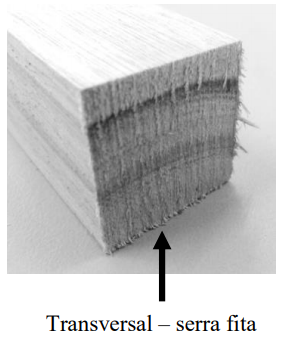


In [2]:
da = pd.read_csv("https://raw.githubusercontent.com/Rsimetti/cursoAP2020/master/Wood_density.csv", decimal = ",", sep = ";")

In [3]:
# Verificando o tamanho do banco de dados
da.shape

(278, 435)

In [4]:
# Valores objetivos
y = da["DB"].values
# Espectros
X = da.drop(["DB", "Material"], axis=1).values
# Comprimento de onda
wl = np.arange(1111, 2500, 3.21)

## Análsie exploratória

Inicialmente faremos a inspeção visual dos espectros e a análise exploratória da variavel resposta.

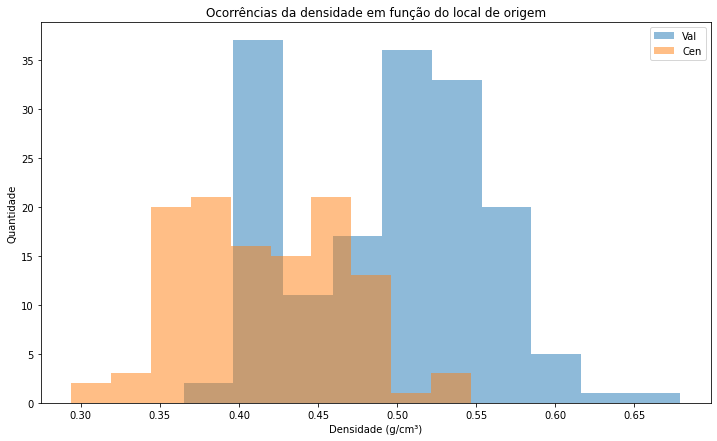

In [5]:
d1 = da.loc[da.Material=="Val", "DB"]
d2 = da.loc[da.Material=="Cen", "DB"]

plt.rcParams["figure.figsize"] = (12,7)
plt.hist(d1, alpha = 0.5, label = "Val")
plt.hist(d2, alpha = 0.5, label = "Cen")
plt.title("Ocorrências da densidade em função do local de origem")
plt.ylabel("Quantidade")
plt.xlabel("Densidade (g/cm³)")
plt.legend()
plt.show()

Aqui podemos observar que cada local apresentou faixas de densidades diferentes, sendo que o local identificado como *Cen* apresentou os menores valores em relação ao local *Val*. 

Para análise visual dos espectros foi calculada a segunda derivida, para destacar as regiões que houveram maiores variações no espectro. Podemos ver na figura abaixo que apesar do locais se diferenciarem em relação a densidade, não houveram diferenças visuais nos espectros. 

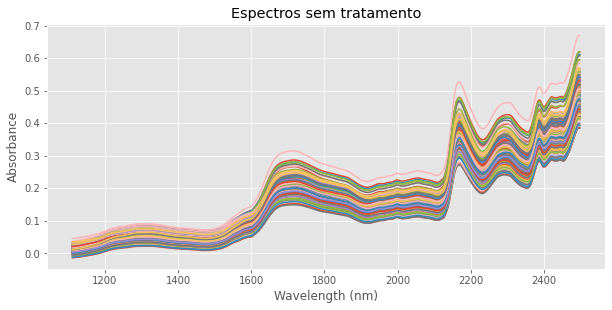

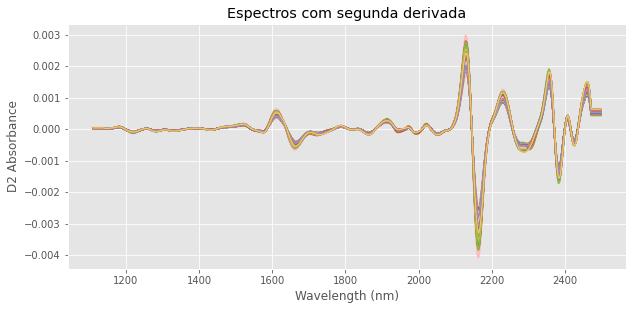

In [6]:
# #Espectros
plt.figure(figsize=(10,4.5))
with plt.style.context(('ggplot')):
    plt.plot(wl, X.T)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Absorbance')
    plt.title("Espectros sem tratamento")
    plt.show()

# Segunda derivada
X2 = savgol_filter(X, 17, polyorder = 2,deriv=2)
# visualizar
plt.figure(figsize=(10,4.5))
with plt.style.context(('ggplot')):
    plt.plot(wl, X2.T)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('D2 Absorbance')
    plt.title("Espectros com segunda derivada")

    plt.show()

## Análise de regressão


Três técnicas de regressão serão utilizadas para predição do valor, são elas:

- Minimos quadrados parciais (PLS) 
- Rede Neural Artificial Perceptrons de Múltiplas Camadas (ANN)
- Florestas Aleatórias (RF)

O uso de PLS ao invés da regressão linear multipla é devido à elevada colinearidade entre os dados espectrais. 

### Criação e avaliação dos modelos de regressão 

inicialmente nornalizamos os dados e dividimos em lotes de treino e teste, na proporção de 80% e 20%, respectivamente. 

In [7]:
# Normalização
X = (X - X.min())/(X.max()-X.min())
y = (y - y.min())/(y.max()-y.min())

In [8]:
# Dividindo os lotes de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2)#random_state=42

O primeiro método utilizado foi o PLS, o unico critério utilizado para otimização desse tipo de modelo é o número de variaveis latentes (VL) (ou componentes) que serão utilizadas na regressão. Para seleção do número de VL iremos utilizar o erro quadrativo médio, de maneira que o menor erro quadrativo médio irá indicar o número de componentes que iremos utilizar.

Text(0, 0.5, 'MSE')

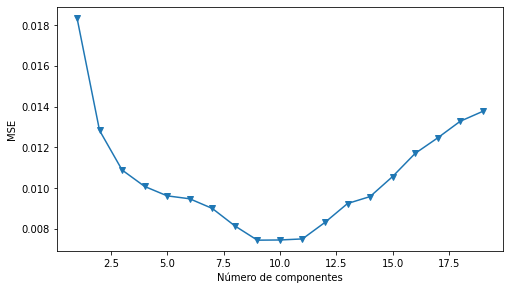

In [9]:
# Adaptado de http://www.science.smith.edu/~jcrouser/SDS293/labs/lab11-py.html
kf_10 = model_selection.KFold(n_splits=10, shuffle=True, random_state=1)

mse = []

for i in np.arange(1, 20):
    pls = PLSRegression(n_components=i)
    score = model_selection.cross_val_score(pls, 
                                            X_train, 
                                            y_train, 
                                             cv=kf_10,
                                            scoring='neg_mean_squared_error').mean()
    mse.append(-score)

# Plotar figura
plt.rcParams["figure.figsize"] = (8,4.5)
plt.plot(np.arange(1, 20), np.array(mse), '-v')
plt.xlabel('Número de componentes')
plt.ylabel('MSE')

Como no treino do modelo o melhor número de componentes foi de 9, iremos calcular as metricas no lote de teste com esse número de componentes.
Agora iremos calcular o modelo para RNA, para isso utilizaremos o método de otimização Grid search com algumas combinações:
* Camada simples com 10, 15 ou 20 neuronios
* Dupla camada com (10,20) ou (20,40) neuronios
* Funções de ativação 
* Solver
* Interações máximas 10.000 ou 5.000


In [10]:
# Definindo os parâmetros para seleção para RNA
param_grid = [
              {
                  'hidden_layer_sizes': [(10),
                                         (15),
                                         (20),
                                         (10,20),
                                         (20,40)],
                  'activation': ['tanh', 
                                 'relu'],
                  'solver': ['lbfgs', 
                             'adam'],
                  'max_iter': [10000,
                               5000]
              }
]


# Criando a RNA para otimização com Grid Search
rna2 = GridSearchCV(MLPRegressor(),
                   param_grid,
                   cv = 10,
                   scoring='neg_mean_squared_error')

In [11]:
# Calculando a melhor rede e o tempo que isso leva
start_time = time.time()
rna2.fit(X_train,y_train)
print("--- %s segundos ---" % (time.time() - start_time))


--- 81.67547917366028 segundos ---


In [12]:
# Salvando a melhor rede e imprimindo os resultados
rna2_ot = rna2.best_estimator_
print(rna2.best_params_)
print(round(rna2.best_score_,7))

{'activation': 'tanh', 'hidden_layer_sizes': 10, 'max_iter': 10000, 'solver': 'lbfgs'}
-0.0087388


Sendo então essa a melhor rede entre aquelas que foram testadas. 
Agora iremos definir o melhor modelo de floresta aleatória. 

In [13]:
# Definindo modelo random forest
param_grid2 = {
    "n_estimators"      : [10,20,30],
    "max_features"      : ["auto", "sqrt", "log2"],
    "min_samples_split" : [2,4,8],
    "bootstrap": [True, False]
    }
# Criando o modelo RF
floresta = GridSearchCV(RandomForestRegressor(),
                        param_grid2,
                        cv = 10,
                        scoring='neg_mean_squared_error')

In [14]:
# Calculando a melhor rede e o tempo que isso leva
start_time = time.time()
floresta.fit(X_train,y_train)
print("--- %s segundos ---" % (time.time() - start_time))

--- 133.58308720588684 segundos ---


In [15]:
# Salvando a melhor rede e imprimindo os resultados
floresta_ot = floresta.best_estimator_
print(floresta.best_params_)
print(round(floresta.best_score_,7))

{'bootstrap': True, 'max_features': 'sqrt', 'min_samples_split': 4, 'n_estimators': 10}
-0.0109043


Tendo encontrado essa como a melhor combinação entre as testadas para RF.
Agora iremos fazer a predição utilizando o lote de teste e comparar os modelos otimizados.

In [16]:
# Regressão 
pls = PLSRegression(n_components=9)
pls.fit(X_train,y_train)
pred_pls = pls.predict(X_test)

# Random forest
floresta_ot.fit(X_train,y_train)
pred_floresta = floresta_ot.predict(X_test)

# Rede Neural
rna2_ot.fit(X_train,y_train)
pred_mlp = rna2_ot.predict(X_test)

In [17]:
#  Métricas
## MAE
mae_rl = mean_absolute_error(y_test,pred_pls)
mae_rf = mean_absolute_error(y_test,pred_floresta)
mae_nn = mean_absolute_error(y_test,pred_mlp)

# RMSE
rmse_rl = mean_squared_error(y_test,pred_pls)**(1/2)
rmse_rf = mean_squared_error(y_test,pred_floresta)**(1/2)
rmse_nn = mean_squared_error(y_test,pred_mlp)**(1/2)

# R^2
r2_rl = r2_score(y_test, pred_pls)
r2_rf = r2_score(y_test, pred_floresta)
r2_nn = r2_score(y_test, pred_mlp)

Métricas dos modelos sem otimização
| Método   |   MAE |   RMSE |    R² |
|----------+-------+--------+-------|
| PLS      | 0.063 |  0.085 | 0.805 |
| RF       | 0.095 |  0.126 | 0.566 |
| ANN      | 0.088 |  0.111 | 0.662 |


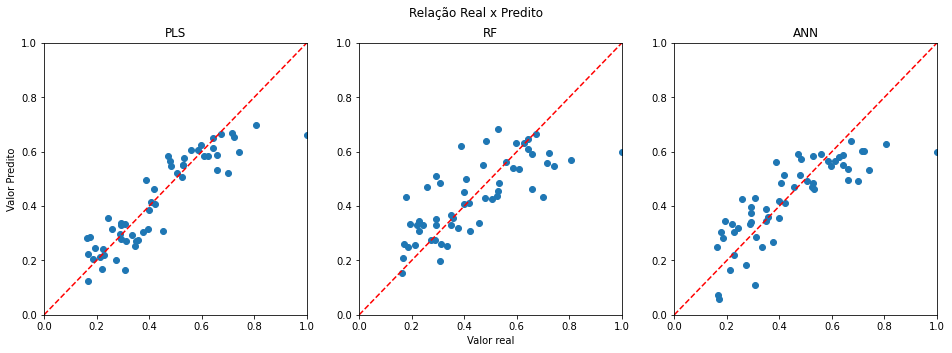

In [18]:
print("=====================================\nMétricas dos modelos sem otimização\n=====================================")

print(tabulate([['PLS', round(mae_rl, 3), round(rmse_rl, 3), round(r2_rl,3)],
                ['RF', round(mae_rf, 3), round(rmse_rf, 3), round(r2_rf,3)],
                ['ANN', round(mae_nn, 3), round(rmse_nn, 3), round(r2_nn,3)]],
               
               headers=['Método', 'MAE', 'RMSE', "R²"], 
               tablefmt='orgtbl'))



# Figura com os valores estimados e reais
fig, (ax0, ax1, ax2) = plt.subplots(nrows = 1, 
                                    ncols = 3, 
                                    sharex = False, 
                                    sharey = False,
                                    figsize = (16, 5))

fig.suptitle('Relação Real x Predito')
ax0.set_ylabel('Valor Predito')
ax1.set_xlabel('Valor real')

# Regressão linear
ax0.set_title('PLS')
ax0.scatter(y_test, pred_pls)
ax0.set_xlim([0, 1])
ax0.set_ylim([0, 1])
line = mlines.Line2D([0, 1], [0, 1], color='red', ls = 'dashed')
ax0.add_line(line)

# Random Forest
ax1.set_title('RF')
ax1.scatter(y_test, pred_floresta)
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
line = mlines.Line2D([0, 1], [0, 1], color='red', ls = 'dashed')
ax1.add_line(line)

# Redes Neurais
ax2.set_title('ANN')
ax2.scatter(y_test, pred_mlp)
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
line = mlines.Line2D([0, 1], [0, 1], color='red', ls = 'dashed' )
ax2.add_line(line)

plt.show()

# Considerações finais

Entre os métodos utilizados o modelo utilizando PLS foi o que apresentou melhores resultados. Como podemos ver na tabela resumo e nas figuras com os resultados do modelos no lote de teste. 
Dois pontos que devem ser levados em conta nesse resultado são:
* Método de amostragem, pois utilizamos a divisão em um lote de teste e outro de validação, devido ao tamanho da amostra. Então o sorteio pode ter afetado o resultado.
* Os parametros dos modelos. Apesar de os modelos RNA e RF terem sido otimizados, as combinações testadas foram muito limtiadas, certamente não são as melhores combinações dentro de todas as possíveis, somente dentro das testadas. Nesse aspecto o modelo PLS foi melhor por apresentar apenas um parametro para a seleção do melhor modelo, o que facilitou a busca da melhor combinação dentro de todo dominio de alternativas. 